Introduction to wavelet theory
=========
by Christopher Schölzel

Author's Note:
---------------
I use this notebook to keep notes about my learning process about wavelet theory.
I hope that these notes may help somebody else in their learning process, but as I am not an expert myself, they may of course contain errros.
If you spot such an error, please let me know. 

My main learning resource currently is "Ten lectures on wavelets" by Ingrid Daubechies[[1]](#ref1). I will therefore probably mostly follow the structure of this book.

<a name="ref1">[1]</a> [Daubechies, I. Ten lectures on Wavelets. (Society for industrial and applied mathematics, 1992).](http://dx.doi.org/10.1137/1.9781611970104)


What is a wavelet?
---------------
So... what exactly are these "wavelets" everybody is talking about? Well, just as a piglet is a small pig, a wavelet is - essentially - a small wave. A very simple example of such small wave is the mexican hat function:

$$m(x) = \frac{2}{\sqrt{3 \sigma} \pi^{\frac{1}{4}}} \left(1-\frac{x^2}{\sigma^2}\right) e^{\frac{-x^2}{2 \sigma^2}}$$

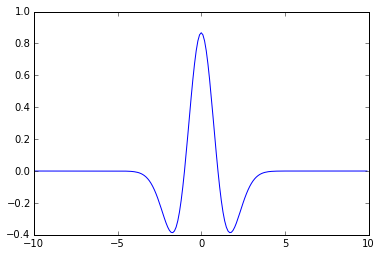

In [2]:
%matplotlib inline
# we will use numpy and matplotlib for all the following examples
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def mexican_hat(x, mu, sigma):
    return 2 / (np.sqrt(3 * sigma) * np.pi**0.25) * (1 - x**2 / sigma**2) * np.exp(-x**2 / (2 * sigma**2) )

xvals = np.arange(-10,10,0.1)
plt.plot(xvals, mexican_hat(xvals, 0, 1))
plt.show()

The mexican hat function/wavelet is the rescaled negative second derivative of the gaussian function (the probability distribution function of the normal distribution).

$$
g(x) = \frac{1}{\sigma \sqrt{2 \pi}} e^{\frac{- (x-mu)^2}{2 \sigma^2}}
$$

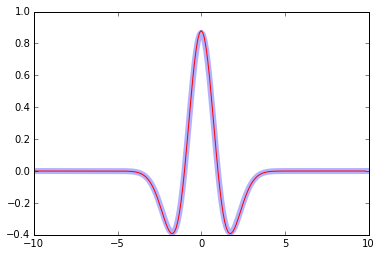

In [3]:
def gauss(x, mu, sigma):
    return 1.0 / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2))

g = gauss(xvals, 0, 1)
m = mexican_hat(xvals, 0, 1)
dg = g[1:] - g[:-1] # linear approximation of first derivative
ddg = dg[1:] - dg[:-1] # linear approximation of second derivative

plt.plot(xvals, m, color="blue", lw=6, alpha=0.3)
fac = m[len(xvals)//2] / -ddg[len(xvals)//2] # scaling factor
plt.plot(xvals[1:-1], -ddg*fac, "r-")
plt.show()

In fact, there are no theoretical limitations to what a wavelet can be. However, for practical purposes, "standard" wavelets, like the mexican hat wavelet, have some desirable properties.
* The integral of a wavelet should be finite.
* For the mexican hat wavelet, the integral is even zero, which means that a convolution with this function will leave the output signal in the same value range as the input signal.

In [4]:
np.sum(m)

0.0

Wavelet theory and the Fourier transform
-----------------------

The wavelet transform is often linked to the fourier transform, because both are used to inspect the frequency spectrum of a signal.

To examine the similarities and differences between the fourier and wavelet transform we will generate some artificial sound data:

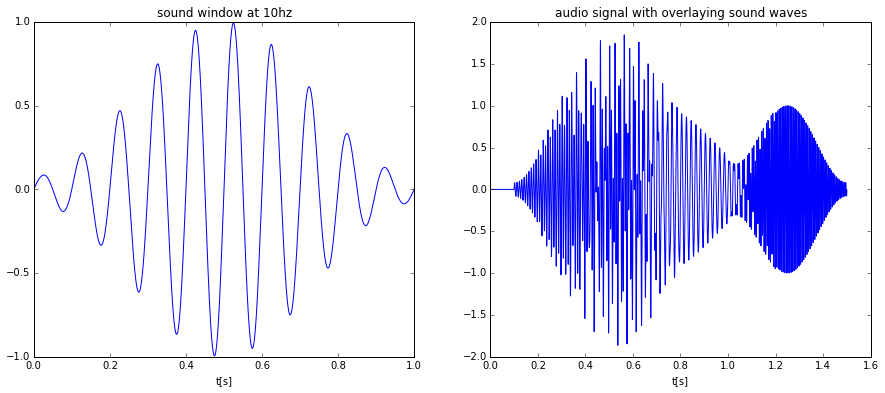

In [5]:
def hamming(n):
    """ Hamming window of size N for smoothing the edges of sound waves """
    return 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(n) / (n-1))

def sound(freq, dur, res=10000):
    ln = dur*res
    sound = np.zeros(ln)
    sound = np.sin(np.arange(ln)*2*np.pi*freq/res)
    return sound * hamming(ln)

def add_sound(audio, loc, freq, dur, res=10000):
    audio[loc:loc+dur*res] += sound(freq, dur, res=res)

res = 10000 # sound resolution in hz
plt.figure(figsize=(15,6))
plt.subplot(121)
snd = sound(10,1)
plt.plot(np.arange(len(snd),dtype="float32")/res,snd)
plt.xlabel("t[s]")
plt.title("sound window at 10hz")

plt.subplot(122)
audio = np.zeros(15000)
add_sound(audio, 1000, 100, 0.5)
add_sound(audio, 3000, 130, 0.5)
add_sound(audio, 2000, 50, 1)
add_sound(audio, 10000, 150, 0.5)
plt.plot(np.arange(len(audio),dtype="float32")/res,audio)
plt.xlabel("t[s]")
plt.title("audio signal with overlaying sound waves")

plt.show()

Now that we have our sample data, we can look at its power spectrum using the fourier transform.

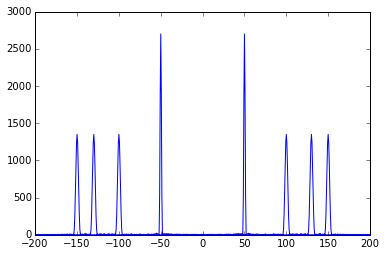

In [6]:
fourier = np.fft.fft(audio)
xvals = np.fft.fftfreq(len(audio))*res
idx = np.where(np.abs(xvals) < 200)
plt.plot(xvals[idx],np.abs(fourier)[idx])
plt.show()

As expected, we see clear peaks at the frequencies that are present in the data (50 hz, 100 hz, 130 hz, and 150 hz).
However, the fourier transform leaves us with no information _where_ these frequencies occurred in the original signal.

For the analysis of sound-related data (and many other types of data with spatial information) it would be desirable to retain this spatial information.
With the fourier transform, we can multiply the original signal with a window function so that we only get the frequency components within that window.
By shifting the window over the signal, we get the information of all frequency bands at all locations.
This technique is called the *windowed Fourier transform*.

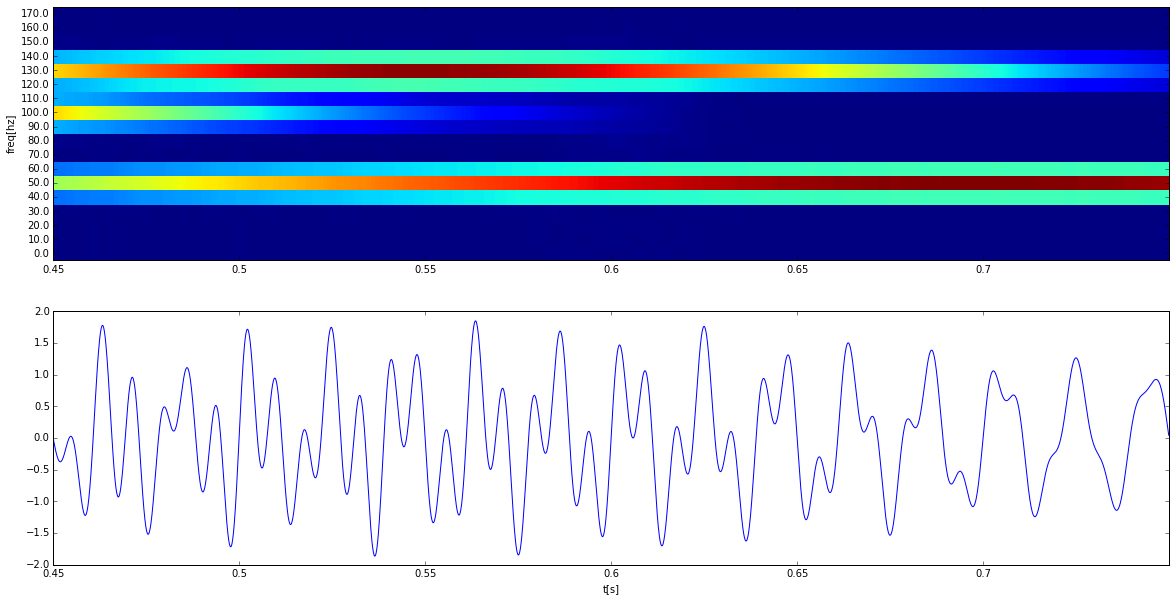

In [7]:
# note: the execution of this code block might take a few seconds
def fourier_w(signal, window_size=1000):
    out = np.zeros((len(signal),window_size))
    window = hamming(window_size)
    for i in range(window_size//2, len(signal)-window_size//2):
        s = i - window_size//2
        e = s + window_size
        wsig = signal[s:e] * window
        out[i,:] = np.abs(np.fft.fft(wsig))
    return out

s,e = 4000,8000 # range of signal
wsize = 1000 # window size
fs,fe = 0,18 # range of frequencies to plot

fw = fourier_w(audio[s:e],window_size=wsize)
fwcut = fw[wsize//2:-wsize//2,fs:fe]
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.pcolormesh(fwcut.T)
yt = np.arange(0,len(fwcut[0]),1)
plt.yticks(yt+0.5,(np.fft.fftfreq(wsize)*res)[yt+fs])
xt = np.arange(0,len(fwcut),wsize//2)
plt.xticks(xt,(xt+s+wsize//2)/res)
plt.ylabel("freq[hz]")
plt.ylim(0,len(fwcut[0]))

plt.subplot(212)
plt.plot(audio[s+wsize//2:e-wsize//2])
plt.xticks(xt, (xt+s+wsize//2)/res)
plt.xlabel("t[s]")
plt.show()

As you can see from the plots above, the windowed fourier transform preserves the spatial information at the cost of a higher computational complexity.
We can see that the 100hz sound fades out at t = 0.6s, which is exactly what we defined: The sound starts at t = 0.1s and has a duration of 0.5s.

The (discrete) wavelet transform essentially aims to solve the same problem as the windowed fourier transform: It provides information about the frequency spectrum without losing the spatial location.

At this point, we could use an existing implementation of the discrete wavelet transform and compare its output to that of the windowed fourier transform.
If you are interested in a ready-to-use version of the DWT for python, I suggest you have a look at Machine Learning PYthon ([mlpy](http://mlpy.sourceforge.net/docs/3.1/index.html)) or PyWavelets ([pywt](http://www.pybytes.com/pywavelets/ref/dwt-discrete-wavelet-transform.html)).
I have not yet tested any of those packages, but they both seem quite mature at first glance.
In this notebook we will take the hard approach of building a dwt for ourselves and understanding it step by step.
We may come back to this example when we are finished with that. ;)

In order to do this, it may first help to recall what the fourier transformation is actually doing.
We therefore define functions that calculate the fourier coefficients manually by multiplying the signal with a sine- and cosine-wave and taking the integral of the result (by summing all values):

In [8]:
def fourier_coeff_i(signal, freq, res=10000):
    """ calculates the imaginary fourier coefficient of signal at frequency freq """
    s = -np.sin(np.arange(len(signal))*2*np.pi*freq/res) # sine wave with given frequency
    return np.sum(signal * s) # integral

def fourier_coeff_r(signal, freq, res=10000):
    """ calculates the real fourier coefficient of signal at frequency freq """
    s = np.cos(np.arange(len(signal))*2*np.pi*freq/res) # sine wave with given frequency
    return np.sum(signal * s) # integral

freqs = [50,70,100,110,120,125,130,140,150]
faudio = np.fft.fft(audio)
fbins = np.fft.fftfreq(len(audio))
coeff_lib = lambda f: faudio[int(np.floor(f/res*len(audio)))]
for f in freqs:
    i = fourier_coeff_i(audio,f)
    r = fourier_coeff_r(audio,f)
    print("{0:3d}hz: {1:5.0f} + {2:5.0f}i (fft: {3.real:5.0f} {3.imag:+5.0f}i)".format(f,r,i,coeff_lib(f)))

 50hz:    -0 + -2700i (fft:    -0 -2700i)
 70hz:    -0 +    -0i (fft:    -0    -0i)
100hz:    -0 + -1350i (fft:    -0 -1350i)
110hz:     0 +    -0i (fft:     0    -0i)
120hz:    -0 +    -0i (fft:    -0    -0i)
125hz:    12 +    -0i (fft:    -3    +3i)
130hz:    -0 + -1350i (fft:    -0 -1350i)
140hz:     0 +    -0i (fft:     0    -0i)
150hz:     0 + -1350i (fft:     0 -1350i)


Now, to introduce the time domain again, we define a function that calculates a single coefficient of the windowed fourier transform for a given time and frequency:

In [9]:
def windowed_fourier(signal, freq, t, wsize=1000, res = 10000):
    window = hamming(wsize)
    s = int(np.floor(t * res - wsize//2))
    wsig = signal[s:s+wsize] * window
    return [f(wsig, freq, res=res) for f in [fourier_coeff_r, fourier_coeff_i]]

args = [
    (50,0.5),
    (50,0.7),
    (150,0.6),
    (150,1.2)
]
for f, t in args:
    r, i = windowed_fourier(audio, f, t)
    print("{0:3d}hz, {1:5.3f}s: {2:+5.0f} {3:+5.0f}i".format(f, t, r, i))

 50hz, 0.500s:    +1  +184i
 50hz, 0.700s:    -1  +269i
150hz, 0.600s:    -2    +1i
150hz, 1.200s:    -0  +243i


With this definition we have a function that can tell us for each frequency at each point in time how much of that frequency is present in our signal.
How would this function look for the wavelet transform?

Well, actually it looks really similar, except that the wavelet is constructed in such a way that the multiplication with the window and the sine/cosine wave is replaced by a convolution of the original signal with the wavelet.
(Remember: Wavelets like the mexican hat wavelet already have a "windowed" shape that drops to zero to both sides.)

Mathematically, the wavelet transform can be defined as follows:

$$
(T^{\text{wav}} f)(a,b) = \sqrt{|a|} \int dt \; f(t) \psi \left(\frac{t-b}{a}\right)
$$

where $a$ is the scale and relates to the frequency f while b is the location parameter relating to the time t.

With this definition, we can take a quick glance how the wavelet transform with a mexican hat wavelet might look like:


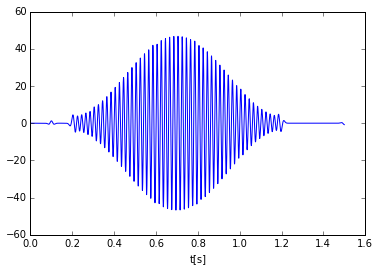

In [10]:
# note the response of a mexican hat wavelet of 1s length is highest for a frequency of approximately 4hz
def twav(signal, f):
    wav = mexican_hat(np.arange(-5,5,10.0/10000 * f/4.0), 0, 1)
    return np.convolve(signal, wav, "same")

# remember: the sound at 50hz starts at t = 0.2s and has a duration of 1s
plt.plot(np.arange(len(audio))/res,twav(audio,50))
plt.xlabel("t[s]")
plt.show()

As you can see, the wavelet transform with the mexican hat function also filters frequency information and retains spatial information.
The response of the transform at 50hz shows where the corresponding sound begins and ends, but the transformed signal also oscillates so that we do not get a clear spectrum.
For higher frequencies, you can also see that the response overlays with the other frequency bands that are nearby.
This is probably because the mexican hat function does not fit the sine waves in the signal perfectly, whereas the sine waves used in the fourier transform do.

However, before we further investigate the theory of the wavelet transform, I would like to return one (probably) last time to the Fourier transform.
It turns out, that the fourier transform for a given frequency can also be interpreted as a convolution much like the wavelet transform.
The only change we need to make is to mirror our windowed sine- and cosine waves at the y axis to counteract the mirroring in the convolution operation.

150hz, 0.600s:    -2    +1i
150hz, 1.200s:    -0  +243i


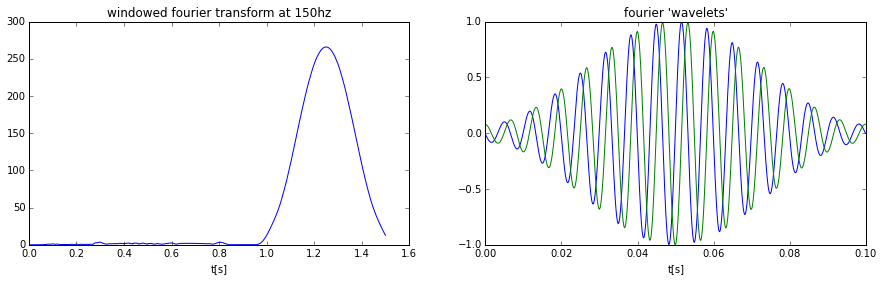

In [11]:
def wfourier_conv(signal, freq, wsize=1000, res=10000):
    window = hamming(wsize)
    x = (wsize-1-np.arange(wsize)) * 2 * np.pi * freq / res
    swindow = window * np.sin(x)
    cwindow = window * np.cos(x)
    sfft, cfft = [np.convolve(signal,x,"same") for x in [swindow, cwindow]]
    return swindow, cwindow, cfft - sfft * 1j 

# remember: we have issued a sound with 150hz at t = 1s with duration 5s
sw150, cw150, f150 = wfourier_conv(audio, 150, res=res)
for t in [6000, 12000]:
    print("{0:3d}hz, {1:5.3f}s: {2.real:+5.0f} {2.imag:+5.0f}i".format(150, t/res, f150[t]))
plt.figure(figsize=(15,4))
plt.subplot(121)
plt.plot(np.arange(len(audio),dtype="float32")/res,np.abs(f150))
plt.title("windowed fourier transform at 150hz")
plt.xlabel("t[s]")

plt.subplot(122)
plt.plot(np.arange(len(sw150),dtype="float32")/res,sw150)
plt.plot(np.arange(len(cw150),dtype="float32")/res,cw150)
plt.title("fourier 'wavelets'")
plt.xlabel("t[s]")
plt.show()

With this representation we can view the fourier transform as a special case of the wavelet transform with a "fourier wavelet".
In fact, the commonly used *Morlet wavelet* is composed of a complex exponential $e^{ix}$ and a gaussian.
The discrete wavelet transform using the Morlet wavelet is therefore identical with a windowed fourier transform using a gaussian window.

The discrete wavelet transform - Once more with feeling!
----------

Now that we have a broad grasp of what the discrete wavelet transform (DWT) actually is, we can start discussing how to do it "properly".
What are good choices for wavelets, how can we compute the DWT efficiently, and what is all the fuzz about "mother"- and "father"-wavelets, high- and lowpass filters and so on?

First, we look again at the definition of the wavelet transform:

$$
(T^{\text{wav}} f)(a,b) = \sqrt{|a|} \int dt \; f(t) \psi \left(\frac{t-b}{a}\right)
$$

This definition uses a single wavelet function, but we can also think of the transform as using several wavelets with different scale and location parameters a and b.
In this (discrete) case we define discrete steps for $a = a_0^m$ and $b = n b_0 a_0^m$.
With this definition, we get:

$$
(T^{\text{wav}} f)(a,b) = T^\text{wav}_{m,n}(f) = \int dt \; f(t) \psi_{m,n} (x)
$$

with

$$
\psi_{m,n} = a_0^{\frac{-m}{2}} \psi\left(a_0^{-m}x - nb_0\right)
$$

Now why do we define our frequency steps in an exponential scale $a_0^m$ instead of a linear scale $m a_0$?
Currently, I do not have a good answer for this, except that it makes things easier if we use $a_0$ = 2, because then we can always double the scale, which seems to make sense.
I would, however, love to hear an explanation of an actual expert in the field, because I am quite sure there is a better explanation than that.
If I find one myself, I will add it here later.

If we accept the exponential scale, the choice of $b$ also becomes reasonable.
We move our wavelet along the signal in steps of some initial step width $b_0$.
This step width can be increased with increasing m (or a respectively), because increasing m means that we increase the width of the wavelet.
Shifting a very wide wavelet in very small steps would give very similar results and therefore just waste computing power.

Let's look a little closer at those wavelets. How does a mexican hat wavelet, for example, look with different values for m and n?

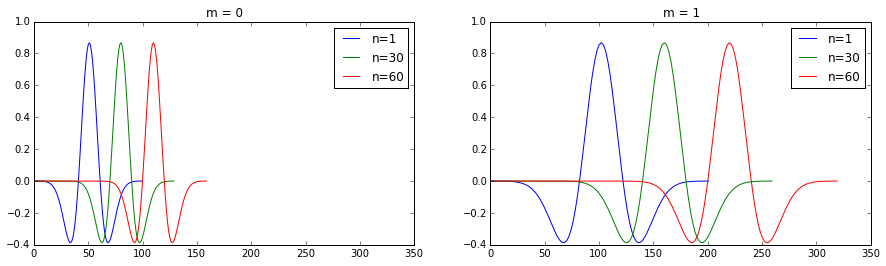

In [12]:
# we assume a0 = 2 and b0 = 1
def psi_mn(psi, m, n):
    a = 2**m
    b = n*2**m
    wav = np.zeros(len(psi)*a + b)
    wav[b:b+len(psi)*a] = np.interp(np.arange(len(psi)*a)/a,np.arange(len(psi)),psi)
    return wav

psi = mexican_hat(np.arange(-5,5,0.1),0,1)
xlim = (0,350)
ns = [1, 30, 60]
ms = [0, 1]
plt.figure(figsize=(15,4))
plt.subplot(121)
for mi in range(len(ms)):
    m = ms[mi]
    plt.subplot(1,len(ms),mi+1)
    for n in ns:
        plt.plot(psi_mn(psi, m, n), label="n="+str(n))
    plt.title("m = "+str(m))
    plt.legend(loc="best")
    plt.xlim(xlim)
plt.show()

We can see that the parameter m dilates the wavelet and the parameter n translates the wavelet along the x-axis.
The figures also show that for the same n, the translation is larger for larger m, but stays the same relative to the size of the wavelet.
Therefore, we can think of the parameter $b_0$ which we fixed to 1 in our example as a parameter that determines how many overlap there will be between two neighboring wavelets.

So how does the DWT look with this definition?
In the following we will look at two implementations:
1. A "naive" implementation `twav_mn_naive` using the transformed wavelets to showcase the idea of the transform.
2. An "efficient" implementation `twav_mn` that shows how many operations are actually needed.

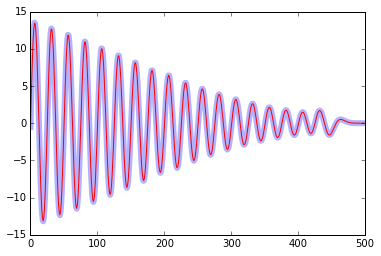

In [13]:
def twav_mn(f, psi, m, n):
    f_scaled = f[::2**m]
    # we have 2 scaling factors: 2**(-m/2.0) from the formula and 2**m from our step length
    # => total scaling factor is 2**(-m/2.0) * 2**m = 2 ** (m - m/2.0) = 2**(m/2.0)
    return 2**(m/2.0) * np.sum(f_scaled[n:n+len(psi)] * psi)

def twav_mn_naive(f, psi, m, n):
    pmn = psi_mn(psi, m, n)
    return 2**(-m/2.0) * np.sum(f[:len(pmn)] * pmn)

m = 3
ns = np.arange(1000,1500)
plt.plot([twav_mn(audio, psi, m, n) for n in ns],color="blue", lw=6, alpha=0.3)
plt.plot([twav_mn_naive(audio, psi, m, n) for n in ns], "r-")
plt.show()

You can both see that the two implementations yield identical outputs and that `twav_mn` is much more efficient.
Instead of transforming the wavelet, we can subsample our data and only multiply the respective chunk of the (resampled) signal with the unaltered wavelet array.
For $a_0 = 2$ and $b_0 = 1$ the total number of coefficients to calculate for a signal of length $N$ for $m = 0$ will be $N$, as we can center the wavelet psi around any point in the whole signal.
For $m = 1$ however, we only have $\frac{N}{2}$ coefficients to compute because we subsampled our data and $n$ can only range from $0$ to $\frac{N}{2}$.
Repeating this consideration, we arrive at the following formula for the number of total coefficients $c$:

$$
c = N + \frac{N}{2} + \frac{N}{4} + \frac{N}{8} + ... = 2 N
$$

We now have a description of our signal of $N$ datapoints with $2N$ coefficients.
In doing so, we have not imposed any restriction on our wavelets other than that they are at all "sensible", which can be formulated mathematically as the following requirement for the "mother wavelet" $\psi$:

$$
C_\psi = 2 \pi \int_{-\infty}^{\infty} d\xi \left|\hat{\psi}(\xi)\right| |\xi|^{-1} < \infty
$$

In this formula, $\hat{\psi}$ denotes the fourier transform of the wavelet function.
The condition essentially informally reads as "the wavelet function is only composed of a finite amount of frequencies".
This also means that the total integral of the wavelet function must be zero.

As Daubechies puts it, this leaves "a lot of freedom" on the choice of wavelet functions, but also often leads to "very redundant" descriptions of the signal.
What is there to gain if we let go of this freedom?

Well, we might be interested in finding a wavelet or family of wavelets that allow us to approximate any function - preferably in a way similar to the fourier transform that does not lose any information and can even be reverted.
The magic thing that we are looking for is an "orthonormal basis of $L^2(\mathbb{R})$".
But what does this mean?

An orthonormal basis of a vector space, for example, is a set of unit vectors that are pairwise orthogonal to each other (that's the "orthonormal" part) and each vector in the whole vector space can be written as a linear combination of these vectors (the "basis" part).
In other words, if vectors $\vec{x}$, $\vec{y}$ and $\vec{z}$ constitute an orthonormal basis for $\mathbb{R}^3$, they fullfill the following properties:

$$
|\vec{x}| = |\vec{y}| = |\vec{z}| = 1
$$

$$
\vec{x} \cdot \vec{y} = \vec{x} \cdot \vec{z} = \vec{y} \cdot \vec{z} = 0
$$

$$
\forall{p} \in \mathbb{R}^3 \;\exists a,b,c \in \mathbb{R}:\;\; \vec{p} = a\vec{x} + b\vec{y} + c\vec{z}
$$

This is true for the following exemplary choices for $\vec{x}$, $\vec{y}$ and $\vec{z}$:

$$
\vec{x} = \begin{pmatrix}1 \\ 0 \\ 0\end{pmatrix}, \vec{y} = \begin{pmatrix}0 \\ 1 \\ 0\end{pmatrix}, \vec{z} = \begin{pmatrix}0 \\ 0 \\ 1\end{pmatrix}
$$

$$
\vec{x} = \begin{pmatrix}-1 \\ 0 \\ 0\end{pmatrix}, \vec{y} = \begin{pmatrix}0 \\ 1 \\ 0\end{pmatrix}, \vec{z} = \begin{pmatrix}0 \\ 0 \\ 1\end{pmatrix}
$$

$$
\vec{x} = \begin{pmatrix}\sqrt{\frac{1}{2}} \\ \sqrt{\frac{1}{2}} \\ 0\end{pmatrix}, \vec{y} = \begin{pmatrix}-\sqrt{\frac{1}{2}} \\ \sqrt{\frac{1}{2}} \\ 0\end{pmatrix}, \vec{z} = \begin{pmatrix}0 \\ 0 \\ 1\end{pmatrix}
$$

(In the last example, we have just rotated all vectors of the first example by $45^\circ{}$ around the z-axis.)

So much for an orthonormal basis.
What exactly is $L^2(\mathbb{R})$?

The term $L^2(\mathbb{R})$ is a shorthand for the set of functions $f: \mathbb{R} \rightarrow \mathbb{R}$ that is square integrable, i.e. $\int dx |f(x)|^2 < \infty$. 

**To cut a long story short this means that if the $\psi_{m,n}$ are an orthonormal basis of $L^2(\mathbb{R})$, every square integrable function can be expressed as a linear combination of these $\psi_{m,n}$.**

How can we find such $\psi_{m,n}$? This question turns out to be not so easy to answer, but we may look at a fairly easy example given by Daubechies: The Haar wavelet.

### Haar Haar, I am captain wavelet!

To finally see some code again, we construct a random function that we want to approximate.
Since we are in the discrete world, we can of course look at this function as being piecewise constant at our given scale of resolution.

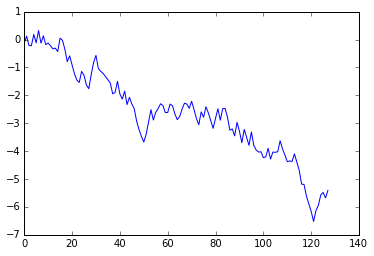

In [14]:
# generate a random walk
# note: for reasons of simplicity we choose the length of our function to be 2^n
# all code below can be made to work with signals of arbitrary length, but it
# would make some examples less readable
rfunc = np.cumsum(np.random.random(128)-0.5)
plt.plot(rfunc)
plt.show()

We will now try to approximate this function with haar wavelets.
The "mother" Haar wavelet is defined as follows:

$$
\psi(x) = \begin{cases} 1 & 0 \leq x < \frac{1}{2} \\ -1 & \frac{1}{2} \leq x < 1 \\ 0 & \text{otherwise}\end{cases}
$$

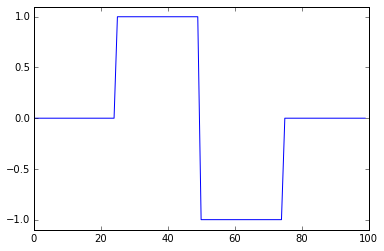

In [15]:
def haar(width):
    h = np.zeros(width)
    h[:width//2] = 1
    h[width//2:] = -1
    return h

h50 = np.zeros(100)
h50[25:75] = haar(50)
plt.plot(h50)
plt.ylim(-1.1,1.1)
plt.show()

The essential trick for our approximation is to write our "function" `rfunc` as the sum of a more "coarse" function and some delta function that holds the difference of this approximation function and the original function.
In mathematical terms we define:

$$
f = f^1 + \delta_1
$$

If we now define $f^1$ to be a function that is piecewise constant at half the resolution of the original function, we can simply compute $f^1$ by averaging every two values of $f$:

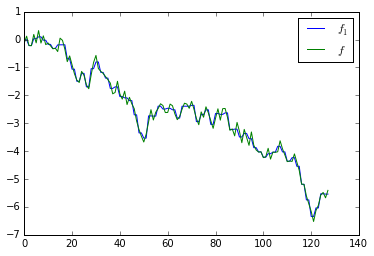

In [16]:
def haar_split(f):
    approx = 0.5*(f[::2]+f[1::2])
    detail = f - np.repeat(approx, 2)
    return approx, detail

rfunc_1, delta_1 = haar_split(rfunc)
plt.plot(np.repeat(rfunc_1,2), label="$f_1$")
plt.plot(rfunc, label="$f$")
plt.legend()
plt.show()

The interesting part of this split is the $\delta_1$.
Because we defined the values of $f_1$ to be the average of two adjacent values of $f$, two adjacent values of $\delta_1 = f - f_1$ will always have the same absolute value and will only differ in the sign.

We can easily demonstrate this property in python:

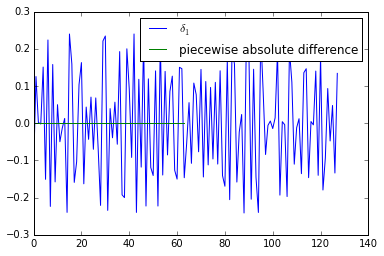

In [17]:
delta_diff = np.abs(delta_1[::2])-np.abs(delta_1[1::2])

plt.plot(delta_1, label="$\delta_1$")
plt.plot(delta_diff, label="piecewise absolute difference")
plt.legend()
plt.show()

We can now exploit this property by "fitting" a haar wavelet to these adjacent pairs.
All we need to do is to scale the mother wavelet by $\delta_1(2k)$ and translate it to the appropriate location.

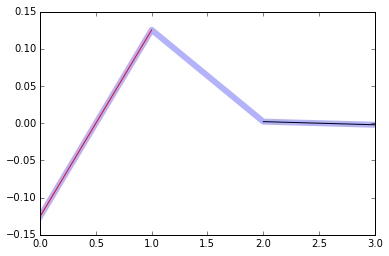

In [18]:
plt.plot(delta_1[:4],color="blue", lw=6, alpha=0.3)
plt.plot([0,1],haar(2)*delta_1[0],"r-")
plt.plot([2,3],haar(2)*delta_1[2],"k-")
plt.show()

For our whole $\delta_1$ the fit then looks as follows:

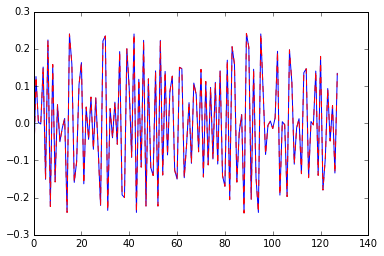

In [19]:
def haar_fit(delta):
    fit = np.zeros(len(delta))
    for i in range(len(delta)//2):
        fit[2*i:2*(i+1)] = haar(2) * delta[2*i]
    return fit

plt.plot(delta_1)
plt.plot(haar_fit(delta_1),"r--")
plt.show()

In other words, we now have a description of $\delta_1$ in terms of coefficients for our haar wavelets:

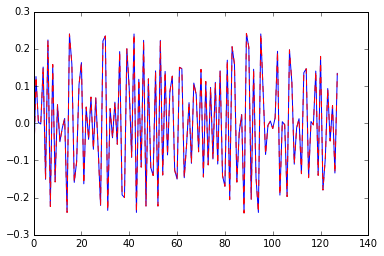

In [20]:
def haar_coeff(delta):
    return delta[::2]

def haar_reconst(coeff):
    return np.tile(haar(2),len(coeff)) * np.repeat(coeff,2)

plt.plot(delta_1)
plt.plot(haar_reconst(haar_coeff(delta_1)),"r--")
plt.show()

We are of course still left with $f_1$ which needs to be approximated.
For this function, we can repeat the process and again define

$$
f_1 = f_2 + \delta_2
$$

in the same way as before with haar wavelets of width 4 instead of width 2.
We can do this until our function is reduced to a totally constant function (the constant being the mean value of the whole function).

For the proof that the approximation using just haar wavelets can be made arbitrarily precise, Daubechies continues to apply the same technique at even larger scales, but for practical purposes we can just use this mean as our final parameter for our approximation.
This has a nice analogy to the fourier transform, since the 0hz component of a fourier transform (called the DC component) is also just the mean of the whole signal.

With this we can write our DWT using haar wavelets as follows:

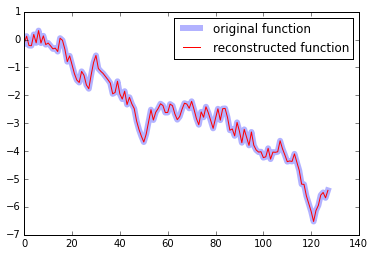

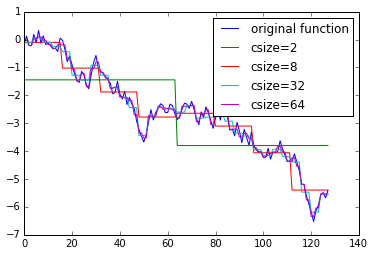

In [21]:
def dwt_haar(signal):
    approx, detail = haar_split(signal)
    coeffs = []
    while len(approx) > 1:
        coeffs.extend(haar_coeff(detail))
        approx, detail = haar_split(approx)
    coeffs.extend(haar_coeff(detail))
    coeffs.append(approx)
    return coeffs

def inv_dwt_haar(coeffs, plot_steps=[]):
    signal = np.array([coeffs[-1]]) # last coefficient is the mean
    csize = 1
    cidx = len(coeffs) - 1
    while cidx > 0:
        signal = np.repeat(signal, 2)
        signal += haar_reconst(coeffs[cidx-csize:cidx])
        cidx -= csize
        csize *= 2
        if csize in plot_steps:
            plt.plot(np.repeat(signal,len(coeffs)//len(signal)), label="csize="+str(csize))
    return signal

coeffs = dwt_haar(rfunc)
plt.plot(rfunc, label="original function",color="blue", lw=6, alpha=0.3)
plt.plot(inv_dwt_haar(coeffs),"r-", label="reconstructed function")
plt.legend()
plt.show()

plt.plot(rfunc, label="original function")
inv_dwt_haar(coeffs, plot_steps=[2, 8, 32, 64])
plt.legend()
plt.show()

As you can see the coefficients of the DWT using a Haar wavelet describe the approximated function across different scales or in different levels of details.
One can also say that the coefficients of each scale correspond to a certain frequency.
The coefficients with low step width correspond to high frequencies while the coefficients with large step width correspond to low frequencies.

The Haar wavelet is mostly only an academic example of a wavelet for which it is easy to construct an orthonormal basis of $L^2(\mathbb{R})$ and prove that the construction works.
There are, of course, other orthonormal wavelet bases that have more practically relevant properties.

In fact, there is a recipe for constructing a function $\psi(x)$ that can be used to construct such an orthonormal basis.
The only ingredient of this recipe is a *scaling function* $\phi(x)$ for which the $\phi_{0,n}$ constitute an orthonormal basis for the space $V_0 = \lbrace f \in L^2(\mathbb{R}); \; f \text{ is piecewise constant on } [k,k+1] \text{ for } k \in \mathbb{Z} \rbrace$.

For such a scaling function $\phi(x)$, a corresponding function $\psi(x)$ can be constructed as follows:

$$
\phi(x) = \sum_{n=-\infty}^{\infty} (-1)^n \alpha_{-n + 1} \phi(2x -n)
$$

$$
\alpha_n = \sqrt{2} \sum_{x = -\infty}^{\infty} \phi(x) \phi_{-1,n}(x)
$$

$$
\phi_{-1,n} = \sqrt{2} \phi(2x -n)
$$

The following python code demonstrates this construction for the haar wavelet function where we can use

$$
\phi(x) = \begin{cases}1 & 0 \leq x < 1 \\ 0 & \text{otherwise}\end{cases}
$$

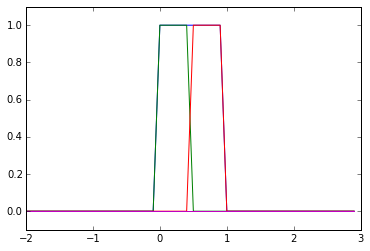

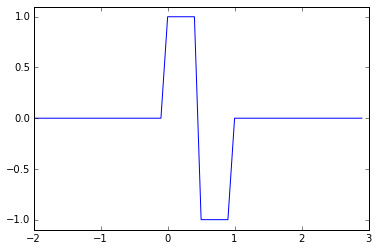

In [22]:
def phi_haar_f(x):
    return 1 if x >= 0 and x < 1 else 0

def alpha_f(n, func, xvals=np.arange(-1,10,0.1), dt=0.1):
    f = [2 * func(x) * func(2*x -n) for x in xvals]
    return np.sum(f) * dt

def psi_f(x, phi, nvals=range(10)):
    return sum([(-1)**n * alpha_f(-n + 1, phi) * phi(2*x - n) for n in nvals])

xvals = np.arange(-2,3,0.1)
plt.plot(xvals,[phi_haar_f(x) for x in xvals])
for n in range(4):
    alpha_n = alpha_f(n, phi_haar_f)
    phi_m1 = np.array([phi_haar_f(2*x - n) for x in xvals])
    plt.plot(xvals,phi_m1*alpha_n)
plt.ylim(-0.1,1.1)
plt.show()

psi_haar = [psi_f(x, phi_haar_f) for x in xvals]
plt.plot(xvals, psi_haar)
plt.ylim(-1.1,1.1)
plt.show()

The first plot illustrates the fact that $\phi(x) = \sum_{n = -\infty}^{\infty} \alpha_n \phi(2x -n)$ while the second plot shows how the construction recipe really does produce the haar wavelet.

This code is of course rather clumsy as it somewhat mixes the continuous and the discrete point of view. We will now try to write the same recipe for the general discrete case.

alpha_f(-1): 0.0, alpha(-1): 0.0
alpha_f( 0): 1.0, alpha( 0): 1.0
alpha_f( 1): 1.0, alpha( 1): 1.0
alpha_f( 2): 0.0, alpha( 2): 0.0
alpha_f( 3): 0.0, alpha( 3): 0.0


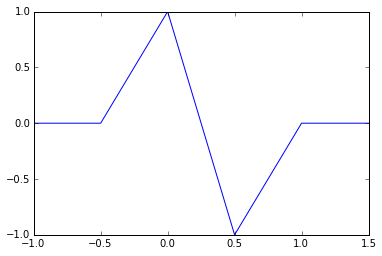

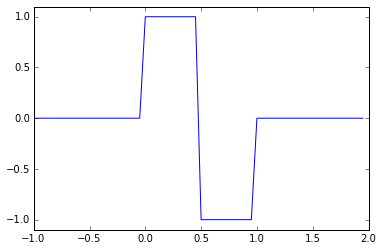

In [23]:
def phi_haar(width):
    return np.ones(width)

def alpha(n, phi):
    # blow up phi => phi[x] = phi2[2*x]
    phi2 = np.repeat(phi,2)
    n = 2*n
    start = max(0, n//2)
    end = min(len(phi2),(len(phi2) + n)//2)
    xs = np.arange(start, end)
    xs2 = 2*xs - n
    return np.sum(phi2[xs] * phi2[xs2])

def psi(phi):
    s = np.zeros(len(phi)*2)
    ns = range(1-len(phi), len(s))
    for n in ns:
        a = alpha(-n + 1, phi)
        before = min(max(0,n),len(phi))
        after = len(phi)-before
        phi_tmp = np.pad(phi,(before,after),"constant")
        sign = -1 if n % 2 == 1 else 1
        s += sign * a * phi_tmp
    return s

for n in range(-1,4):
    tmpl = "alpha_f({0:2d}): {1:.1f}, alpha({0:2d}): {2:.1f}"
    print(tmpl.format(n,alpha_f(n, phi_haar_f),alpha(n,phi_haar(1))))

psi_haar_6 = np.zeros(6)
psi_haar_6[2:4] = psi(phi_haar(1))
plt.plot(np.arange(-1,2,0.5),psi_haar_6)
plt.show()

psi_haar_60 = np.repeat(psi_haar_6,10)
plt.plot(np.arange(-1,2,0.05),psi_haar_60)
plt.ylim(-1.1,1.1)
plt.show()

This second implementation is more computationally efficient and generally applicable at the cost of being a little less readable.
However, one can still see that the "mother wavelet" $\psi$ can be constructed from a series of shifted and scaled versions of the "scaling function" $\phi$.
$\phi$ is therefore sometimes called the "father wavelet", which is a little bit confusing since father and mother are not two independent individuals needed to produce the child wavelets, but rather the "father" can be used to construct the "mother".
(It sounds rather strange if you put it that way.)

There is actually a second alternative to define $\psi$ by defining it's fourier transform $\hat{\psi}$ from the fourier transform of $\phi$.
We will not go into detail about this construction stratgey, but for the sake of completeness I will briefly introduce the corresponding formula:

$$
\hat{\psi}(\xi) = e^{\frac{i\xi}{2}} m_0\left(\frac{\xi}{2} + \pi\right) \hat{\phi}\left(\frac{\xi}{2}\right)
$$

$$
m_0(x) = \frac{1}{\sqrt{2}} \sum_{n=-\infty}^{n=\infty} h_n e^{-in\xi}
$$

$$
h_n = \sqrt{2} \sum_{x=-\infty}^{\infty} \phi(x) \phi(2x-n)
$$

With this we can leave the Haar wavelet behind.
We have found a construction recipe for orthonormal wavelet bases and we know what the terms father wavelet and mother wavelet mean.
What is missing is a really efficient algorithm to compute the DWT which will also bring us to the description of the DWT as a set of low- and high-pass filters.

The DWT as subband filtering scheme
------

TODO: Better explanation for formulas?

Wavelet tutorials often explain the DWT as passing the input sequence through a set of high- and low-pass filters.
For me, this was confusing as my understanding of wavelets was based on an understanding of the fourier transform.
In this introduction, we also have not yet encountered any low-pass filters, or have we?

In fact, we cab really express the DWT as a so called "subband filtering scheme", which automatically gives rise to an efficient implementation of the DWT.

First of all we need to reformulate our definition of the DWT. With the $h_n$ notation from the last section we currently have:

$$
\psi = \sum_{n = -\infty}^{\infty} g_n \phi_{-1, n}
$$

$$
g_n = \sum_{x = -\infty}^{\infty} \psi(x) \phi_{-1, n}(x) = (-1)^n h_{-n+1}
$$

With this the $\psi_{j, k}$ become

$$
\psi_{j,k}(x) = \sum_{n=-\infty}^{\infty} g_{n-2k} \phi_{j-1, n}(x)
$$

**Note:** At this point I will switch notations. For the sake of clarity I used $\sum_{x = -\infty}^{\infty} f(x) g(x)$ where Daubechies used the notation $\langle f, g \rangle$ which is indeed shorter and easier to read once one becomes familiar with the notation. I will probably go back and change the notation throughout the entire document once I find the time.

However, we actually do not need $\psi_{j,k}$ but only our wavelet coefficients $\langle f, \psi_{j,k} \rangle$ which are given by

$$
\langle f, \psi_{j,k} \rangle = \sum_{n = -\infty}^{\infty} g_{n-2k} \langle f, \phi_{j-1, n} \rangle
$$

This definition can again be rewritten as a convolution followed by a downsampling by factor 2 (retaining only the even samples):

$$
\langle f, \psi_{j,k} \rangle =  \left( (\langle f, \phi_{j-1, n} \rangle)_{n \in \mathbb{Z}} * (g_{-n})_{n \in \mathbb{Z}} \right) \downarrow 2
$$

All we need to know to exploit this computation scheme are the $\langle f, \phi_{j-1, k} \rangle$ for which we can also find a convenient definition:

$$
\langle f, \phi_{j,k} \rangle = \sum_{n = -\infty}^{\infty} h_{n-2k} \langle f, \phi_{j-1,n} \rangle
$$

$$
\langle f, \phi_{j,k} \rangle = \left( (\langle f, \phi_{j-1, n} \rangle)_{n \in \mathbb{Z}} * (h_{-n})_{n \in \mathbb{Z}} \right) \downarrow 2
$$

So, to sum up we now have the following algorithm:
* calculate the $\langle f, \phi_{0, n} \rangle$
* calculate $h_n$ and $g_n$ (only needs to be done once for a given $\phi$)
* loop for $j = 1, 2, 3, \dots, j_{\text{max}}$
 * calculate $\langle f, \phi_{j, k} \rangle$ from $h_n$ and $\langle f, \phi_{j-1,k} \rangle$
 * calculate $\langle f, \psi_{j,k} \rangle$ from $g_n$ and $\langle f, \phi_{j-1,k} \rangle$
* store the "detail coefficients" $\langle f, \psi_{j,k} \rangle$ for all $j$ and $k$ and the remaining "approximation coefficients" $\langle f, \phi_{j_{\text{max}}, k} \rangle$

How is this algorithm related to subband filtering?
Well, the sequence $(h_{-n})_{n \in \mathbb{Z}}$ can be seen as a high-pass filter that produces successively "coarser" approximations of the original signal while the sequence $(g_{-n})_{n \in \mathbb{Z}}$ constitutes a low pass filter that captures the details lost in this approximation.
The convolution followed by a downsampling is the same operation as applying the corresponding filter.

We have now seen a lot of formulas, so it's time again to produce some code. Our (possibly last) version of the DWT:

TODO: explain reconstruction (upsampling with interleaving zeros!)

h [ 0.          0.70710677  0.70710677]
g [ 0.         -0.70710677  0.70710677]


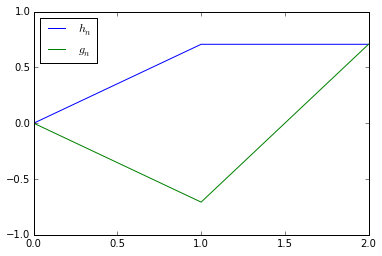

In [24]:
def filters_hg(phi):
    """
    Constructs the filters h and g
    """
    phi2 = np.repeat(phi,2)
    # we only need the indices [-len(phi)+1, len(phi)*2) but we want the
    # filter to be centered at index zero
    ns_h = np.arange(-len(phi)+1,len(phi)*2)
    ns_g = - ns_h + 1
    ns_g = ns_g[::-1]
    hs = np.zeros(len(ns_h), dtype="float32")
    gs = np.zeros(len(ns_h), dtype="float32")
    for i in range(len(ns_h)):
        n_h = 2*ns_h[i]
        n_g = 2*ns_g[i]
        start = max(0, n_h//2)
        end = min(len(phi2),(len(phi2) + n_h)//2)
        xs = np.arange(start, end)
        xs2 = 2*xs - n_h
        # we need to divide by two because we operate on a "blown up" version of phi
        hs[i] = np.sqrt(2) * np.sum(phi2[xs] * phi2[xs2]) / 2.0
        gs[len(gs)-1-i] = -(n_g % 4 - 1) * hs[i]
    # we want our filters to be centered at index zero => add zeros at front or back as required
    add_front_h = len(phi)  # len(phi)*2-1 = last index, -len(phi)+1 = first index => difference = len(phi)
    add_back_g = len(phi)-2 # -len(phi)*2 + 2 = first index, len(phi) = last index => difference = len(phi)-2
    hs = np.pad(hs, (add_front_h, 0), "constant")
    gs = np.pad(gs, (max(0,-add_back_g), max(0, add_back_g)), "constant")
    return hs, gs

hs, gs = filters_hg(phi_haar(1))
print("h", hs)
print("g", gs)
plt.plot(hs, label="$h_n$")
plt.plot(gs, label="$g_n$")
plt.ylim(-1,1)
plt.legend(loc="best")
plt.show()

For the Haar basis we again see the typical shapes of the mother and father wavelets.
However, it is important to note that in general of course $h_n \neq \phi$ and $g_n \neq \psi$.
The equalities in this case are just a coincidence, because the high-pass filter $h_n$ smoothes the signal by averaging adjacent values while the low-pass filter $g_n$ retains exactly the high-frequency fluctuations that are removed by $h_n$.

With this first example we will now continue by looking at a single decomposition and reconstruction step of our subband filtering scheme.

In [88]:
def upsampleZero(ar,n):
    """ upsampling function that adds zeros between the sample values """
    res = np.zeros(len(ar)*n)
    res[::n] = ar
    return res

def sbf_split(data, h, g):
    """ decomposition by convolution and downsampling """
    # set starting points so that first filter position is centered at data[0]
    sh, sg = (len(h)//2, len(g)//2)
    approx = np.convolve(data, h[::-1], "full")[sh:sh+len(data):2]
    detail = np.convolve(data, g[::-1], "full")[sg:sg+len(data):2]
    return approx, detail

def sbf_reconst(approx, detail, h, g):
    """ reconstruction by upsampling and convolution """
    # set starting points so that first filter position is centered at approx[0]/detail[0]
    sh, sg = (len(h)//2, len(g)//2)
    data =  np.convolve(upsampleZero(approx, 2), h, "full")[sh:sh+len(approx)*2]
    data += np.convolve(upsampleZero(detail, 2), g, "full")[sg:sg+len(detail)*2]
    return data

h, g = filters_hg(phi_haar(1))
#h = [0, 0.7071, 0.7071]
#g = [0, -0.7071, 0.7071]
data = [1,2,3,4]
cs, ds = sbf_split(data, h, g)
recs = sbf_reconst(cs, ds, h, g)
print("c_0 (orig.) ",data)
print("c_1         ",cs)
print("d_1         ",ds)
print("c_0 (rec.)  ",recs)

c_0 (orig.)  [1, 2, 3, 4]
c_1          [ 2.12132031  4.94974738]
d_1          [ 0.70710677  0.70710677]
c_0 (rec.)   [ 0.99999997  1.99999993  2.9999999   3.99999986]


This simple example shows how the subband filtering works.
We decompose our $\langle f, \phi_{0,n} \rangle = c^0 = (1, 2, 3, 4)$ by convolving the sequence with $(h_{-n})_{n \in \mathbb{Z}}$ and $(g_{-n})_{n \in \mathbb{Z}}$ to obtain our detail coefficients $d^1 = \langle f, \psi_{1,n} \rangle$ and approximation coefficients $c^1 = \langle f, \phi_{1,n} \rangle$.

Later, we can reconstruct $c^0$ from $c^1$ and $d^1$ by

$$
c^0 = \left( c^1 * (h_{n})_{n \in \mathbb{Z}}\right) \uparrow 2 + \left( d^1 * (g_{n})_{n \in \mathbb{Z}}\right) \uparrow 2
$$

The DWT as subband filtering scheme is now nothing more than the repetition of this same operation until the approximation sequence is sufficiently small (we will reduce the approximation to length 1).

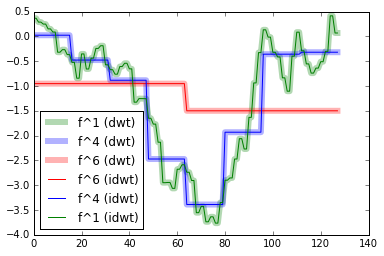

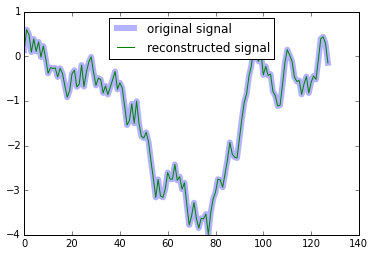

In [154]:
def approx_f(coeffs, phi, j=0):
    """ reconstructs the actual function approximation from approximation coefficients """
    # TODO this has to be checked for correctness for any other wavelet basis than Haar wavelets
    return 2**(-j/2.0) * np.correlate(coeffs, phi, "same")

def phi0(signal, phi):
    return np.convolve(signal, phi, "same")

def dwt_subband(signal, phi, plot_steps=[], colors={}):
    hs, gs = filters_hg(phi)
    phi0n = phi0(signal, phi)
    approx = phi0n
    coeffs = []
    while len(approx) > 1:
        approx, detail = sbf_split(approx, hs, gs)
        if len(approx) in plot_steps:
            j = np.log2(len(signal)/len(approx))
            l = "f^{:.0f} (dwt)".format(j)
            plt.plot(np.repeat(approx_f(approx, phi, j), 2**j), lw=6, alpha=0.3, color=colors[len(approx)], label=l)
        coeffs.append(detail)
    coeffs.append(approx)
    return coeffs

def inv_dwt_subband(coeffs, phi, plot_steps=[], colors={}):
    hs, gs = filters_hg(phi)
    psi_base = psi(phi)
    approx = coeffs[-1]
    idx = len(coeffs)-2
    while idx >= 0:
        detail = coeffs[idx]
        approx = sbf_reconst(approx, detail, hs, gs)
        if len(approx) in plot_steps:
            l = "f^{:.0f} (idwt)".format(idx)
            plt.plot(np.repeat(approx_f(approx, phi, idx), 2**idx), color=colors[len(approx)], label=l)
        idx -= 1
    return approx_f(approx, phi)

filter_len = 128
filter_signal = np.cumsum(np.random.random(filter_len)-0.5)

steps = [2, 8, 64]
colors = {2 : "red", 8: "blue", 64: "green"}
dsb = dwt_subband(filter_signal, phi_haar(1), plot_steps=steps, colors=colors)
dsbi = inv_dwt_subband(dsb, phi_haar(1), plot_steps=steps, colors=colors)
plt.legend(loc="best")
plt.show()

plt.plot(filter_signal, lw=6, alpha=0.3, label="original signal")
plt.plot(dsbi, label="reconstructed signal")
plt.legend(loc="best")
plt.show()

TODO:
* describe these results
* all DWTs can de described as subband filtering, but not all subband filtering schemes are equivalent to some DWT
* IIR vs FIR
 * all "closed-form" wavelets correspond to IIR filters
 * for efficient implementation, FIR filters are better
 * construction of FIR filters from trigonometric polynomials
 * $\Rightarrow$ Daubechies, Symlets
* construction of other wavelets (Meyer, Battle-Lemarie, ...)
* frames?